# Elo ranking



- Première prédiction à partir des scores Elo juste avant le match
- Préparation du fichier en utilisant les scores Elo avant march madness pour prédire le march madness (tous les matchs de saison régulière et des saisons précédentes sont utilisés pour prédire le match madness d'une saison)


In [72]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
import random as rd

sns.set_style("darkgrid")
sns.set_context("notebook")

In [2]:
mean_elo = 1500
elo_width = 400
k_factor = 64

## Load the data

In [3]:
data_dir = '/Users/axel/Desktop/hackaton/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MDataFiles_Stage1/'

df_reg = pd.read_csv(data_dir + 'MRegularSeasonCompactResults.csv')
df_tour_mncaa = pd.read_csv(data_dir + 'MNCAATourneyCompactResults.csv')
df_tour_msecondary = pd.read_csv(data_dir + 'MSecondaryTourneyCompactResults.csv')

- Concatenate the datasets
- Clean them
- Sort them chronologically

In [4]:
df_reg['Tournament'] = ['RegularSeason' for i in range(len(df_reg))]
df_tour_mncaa['Tournament'] = [ 'NCAA'for i in range(len(df_tour_mncaa))]
df_tour_msecondary['Tournament'] = ['SecondaryTourney' for i in range(len(df_tour_msecondary))]

df_concat = pd.concat((df_reg, df_tour_mncaa), ignore_index=True, sort = True)
df_concat = pd.concat((df_concat, df_tour_msecondary), ignore_index=True, sort = True)

In [5]:
df_concat.drop(labels=[ 'WScore', 'LScore', 'WLoc', 'NumOT'], inplace=True, axis=1)
df_concat.sort_values(by=['Season', 'DayNum'], inplace=True)

le = LabelEncoder()

df_concat['WTeamID_original'] = df_concat.WTeamID
df_concat['LTeamID_original'] = df_concat.LTeamID

df_concat.WTeamID = le.fit_transform(df_concat.WTeamID)
df_concat.LTeamID = le.fit_transform(df_concat.LTeamID)

df_concat.head()

,DayNum,LTeamID,Season,SecondaryTourney,Tournament,WTeamID,WTeamID_original,LTeamID_original
0,20,227,1985,NaN,RegularSeason,127,1228,1328
1,25,253,1985,NaN,RegularSeason,5,1106,1354
2,25,122,1985,NaN,RegularSeason,11,1112,1223
3,25,331,1985,NaN,RegularSeason,64,1165,1432
4,25,346,1985,NaN,RegularSeason,91,1192,1447


## Elo Rating Preparation


- Updates the elo scores after each match
- Create a new column with a unique time


In [6]:
def update_elo(winner_elo, loser_elo):
    
    expected_win = expected_result(winner_elo, loser_elo)
    change_in_elo = k_factor * (1 - expected_win)
    winner_elo += change_in_elo
    loser_elo -= change_in_elo
    
    return winner_elo, loser_elo



def expected_result(elo_a, elo_b):
    
    expect_a = 1.0/(1 + 10 ** ((elo_b - elo_a) / elo_width) )
    
    return expect_a

In [7]:
def update_end_of_season(elos):
    """Regression towards the mean
    """
    
    diff_from_mean = elos - mean_elo
    elos -= diff_from_mean / 3
    
    return elos

In [8]:
df_concat['w_elo_before_game'] = 0
df_concat['w_elo_after_game'] = 0
df_concat['l_elo_before_game'] = 0
df_concat['l_elo_after_game'] = 0

elo_per_season = {}
n_teams = len(le.classes_)
current_elos = np.ones(shape=(n_teams)) * mean_elo

Unique time

In [9]:
df_concat['total_days'] = (df_concat.Season-1985)*365.25 + df_concat.DayNum

df_team_elos = pd.DataFrame(index=df_concat.total_days.unique(), columns=range(n_teams))
df_team_elos.iloc[0, :] = current_elos

df_team_elos.head()

,0,1,2,3,4,5,6,7,8,9,...,356,357,358,359,360,361,362,363,364,365
20.0,1500,1500,1500,1500,1500,1500,1500,1500,1500,1500,...,1500,1500,1500,1500,1500,1500,1500,1500,1500,1500
25.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Update the elo ratings

- iterate on each of the rows of the dataframe


In [10]:
current_season = df_concat.at[0, 'Season']
for row in df_concat.itertuples():
    
    if row.Season != current_season:
        
        current_elos = update_end_of_season(current_elos)
        elo_per_season[row.Season] = current_elos.copy()
        current_season = row.Season
        
    idx = row.Index
    w_id = row.WTeamID
    l_id = row.LTeamID
    w_elo_before = current_elos[w_id]
    l_elo_before = current_elos[l_id]
    w_elo_after, l_elo_after = update_elo(w_elo_before, l_elo_before)
        
    df_concat.at[idx, 'w_elo_before_game'] = w_elo_before
    df_concat.at[idx, 'l_elo_before_game'] = l_elo_before
    df_concat.at[idx, 'w_elo_after_game'] = w_elo_after
    df_concat.at[idx, 'l_elo_after_game'] = l_elo_after
    current_elos[w_id] = w_elo_after
    current_elos[l_id] = l_elo_after
    
    today = row.total_days
    df_team_elos.at[today, w_id] = w_elo_after
    df_team_elos.at[today, l_id] = l_elo_after

In [11]:
df_concat.tail()

,DayNum,LTeamID,Season,SecondaryTourney,Tournament,WTeamID,WTeamID_original,LTeamID_original,w_elo_before_game,w_elo_after_game,l_elo_before_game,l_elo_after_game,total_days
165425,150,151,2019,NIT,SecondaryTourney,299,1400,1252,1806,1839,1810,1778,12568.5
165426,151,76,2019,CBI,SecondaryTourney,277,1378,1177,1623,1659,1665,1629,12569.5
163800,152,176,2019,NaN,NCAA,302,1403,1277,2026,2063,2083,2046,12570.5
163801,152,19,2019,NaN,NCAA,337,1438,1120,2083,2114,2078,2047,12570.5
163802,154,302,2019,NaN,NCAA,337,1438,1403,2114,2142,2063,2036,12572.5


In [12]:
n_samples = 40000
samples = df_concat[df_concat.Season > 2010].sample(n_samples)
loss=0
expected_list = []
for row in samples.itertuples():
    w_elo = row.w_elo_before_game
    l_elo = row.l_elo_before_game
    w_expected = expected_result(w_elo, l_elo)
    expected_list.append(w_expected)
    loss += np.log(w_expected)
print(loss/n_samples)

-0.5674207495577284


Text(0, 0.5, 'Counts')

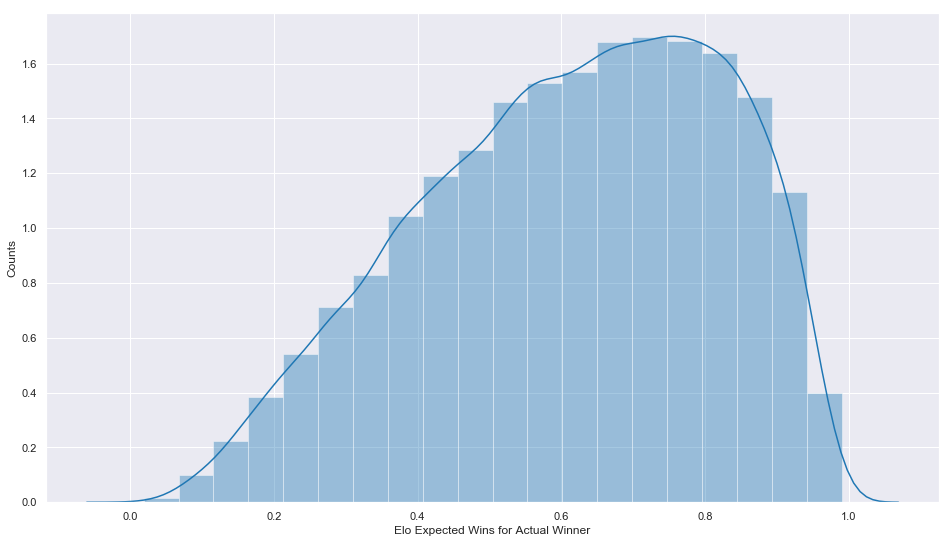

In [13]:
plt.figure(figsize = (16,9))
sns.distplot(expected_list, kde=True, bins=20, )
plt.xlabel('Elo Expected Wins for Actual Winner')
plt.ylabel('Counts')

In [14]:
df_team_elos.fillna(method='ffill', inplace=True)
trans_dict = {i: 'team_{}'.format(i) for i in range(n_teams)}
df_team_elos.rename(columns=trans_dict, inplace=True)
epoch = (df_team_elos.index)
df_team_elos['date'] = pd.to_datetime(epoch, unit='D')

/Users/axel/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Elo rating')

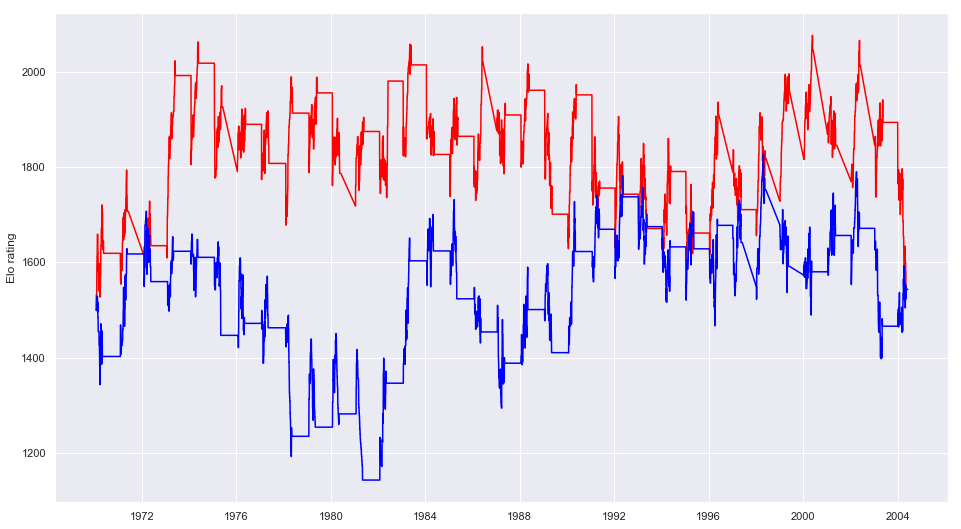

In [15]:
plt.figure(figsize = (16,9))
plt.plot(df_team_elos.date, df_team_elos.team_11, color = 'red')
plt.plot(df_team_elos.date, df_team_elos.team_2, color = 'blue')
plt.ylabel('Elo rating')

## Predictions for the March Madness

- Find the last Elo rating of each team before the March Madness
- Predict each possible match of the March Madness using these ratings

In [16]:
def return_elo_before_NCAA(df_concat, season, TeamID):
    
    NCAA_first_day = min(df_concat[(df_concat.Tournament == 'NCAA') & (df_concat.Season == season)].total_days)
    df_ = df_concat[df_concat.total_days <  NCAA_first_day]
    df_ = df_[(df_concat.LTeamID_original == TeamID) | (df_concat.WTeamID_original == TeamID)]
    
    last_match_day = np.max(df_[(df_concat.LTeamID_original == TeamID)].total_days) 
    won = False
    if(np.isnan(last_match_day) or last_match_day < np.max(df_[(df_concat.WTeamID_original == TeamID)].total_days)):
        last_match_day = np.max(df_[(df_concat.WTeamID_original == TeamID)].total_days)
        won = True
    if(won):
        return df_[df_.total_days ==  last_match_day].w_elo_after_game
    if(not won):
        return df_[df_.total_days ==  last_match_day].l_elo_after_game
        

In [17]:
return_elo_before_NCAA(df_concat, 1985, 1117)

/Users/axel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/Users/axel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/Users/axel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


3604    1476
Name: l_elo_after_game, dtype: int64

In [18]:
#df = pd.DataFrame()

In [19]:
n_samples = 10000
samples = df_concat[df_concat.Season > 2010].sample(n_samples)
loss=0
expected_list = []
for row in samples.itertuples():
    w_elo = row.w_elo_before_game
    l_elo = row.l_elo_before_game
    w_expected = expected_result(w_elo, l_elo)
    expected_list.append(w_expected)
    loss += np.log(w_expected)
print(loss/n_samples)

-0.5743493862241992


In [20]:
submission_model = pd.read_csv('/Users/axel/Desktop/hackaton/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MSampleSubmissionStage1_2020.csv')
submission_model.head()

,ID,Pred
0,2015_1107_1112,0.5
1,2015_1107_1116,0.5
2,2015_1107_1124,0.5
3,2015_1107_1125,0.5
4,2015_1107_1129,0.5


In [21]:
#sub = submission_model.copy()

In [22]:
S_H_A = []
for row in submission_model.iterrows():
    S_H_A.append(list (map(int, row[1].ID.split('_'))))

sub_2 = pd.DataFrame(S_H_A, columns = ['Season', 'Home', 'Away'])

In [23]:
list_ids = (sub_2.Home.append(sub_2.Away)).unique()

In [24]:
list_ids_2 = (df_concat.WTeamID_original.append(df_concat.LTeamID_original)).unique()

In [ ]:
Elos = {}
for season in df_concat.Season.unique():
    Elos[season] = {}
    for id in list_ids:
        Elos[season][id] = return_elo_before_NCAA(df_concat, season, id)

In [ ]:
Elos_2 = {}
for season in df_concat.Season.unique():
    Elos_2[season] = {}
    for id in list_ids_2:
        Elos_2[season][id] = return_elo_before_NCAA(df_concat, season, id)

## Let's try using the rating in the pipeline 

(And see if we lose information compared to using the probability given by Elo's rating)

In [27]:
df_random_forest = pd.DataFrame(columns = ['Season', 'TeamID', 'elo_score'])
for season in df_concat.Season.unique():
    row = [season]
    for id_ in list_ids_2:
        if(list(Elos_2[season][id_]) != []):
            row = [season]
            row.append(id_)
            row.append(int(Elos_2[season][id_]))
            df_random_forest.loc[len(df_random_forest)] = row

In [28]:
df_random_forest.head()

,Season,TeamID,elo_score
0,1985,1228,1768
1,1985,1106,1430
2,1985,1112,1645
3,1985,1165,1446
4,1985,1192,1594


In [29]:
df_random_forest.to_csv("/Users/axel/Desktop/hackaton/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/to_test_random_forest.csv", index = False)

In [30]:
df_random_forest = pd.read_csv("/Users/axel/Desktop/hackaton/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/to_test_random_forest.csv")

In [31]:
elo_Home = []
elo_Away = []
Pred = []

for row in sub_2.iterrows():
    elo_Home.append(int(Elos[row[1]['Season']][row[1]['Home']]))
    elo_Away.append(int(Elos[row[1]['Season']][row[1]['Away']]))
    w = expected_result(elo_Home[-1], elo_Away[-1])
    Pred.append(w)
   
sub_2['elo_Home'] = elo_Home
sub_2['elo_Away'] = elo_Away
sub_2['Pred'] = Pred

In [32]:
sub_2.tail()

,Season,Home,Away,elo_Home,elo_Away,Pred
11385,2019,1449,1459,1788,1884,0.365257
11386,2019,1449,1463,1788,1685,0.644034
11387,2019,1458,1459,1838,1884,0.434185
11388,2019,1458,1463,1838,1685,0.706975
11389,2019,1459,1463,1884,1685,0.758695


In [33]:
submission_model['Pred'] = Pred
submission_model.head()

,ID,Pred
0,2015_1107_1112,0.120683
1,2015_1107_1116,0.272028
2,2015_1107_1124,0.299023
3,2015_1107_1125,0.558731
4,2015_1107_1129,0.400603


In [34]:
submission_model.to_csv("/Users/axel/Desktop/hackaton/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/to_submit.csv", index = False)

## Test with Claire's data and logistic  regression

In [35]:
from sklearn.linear_model import LogisticRegression

In [65]:
df_Claire = pd.read_csv('/Users/axel/Desktop/hackaton/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/features_season_claire.csv')
df_train = pd.read_csv('avec_claire_et_elo.csv')
df_train.head()

,Unnamed: 0,victoire,Season,TeamID_1,TeamID_2,elo_1,elo_2,p_win_elo,Nombre_victoires_1,Nombre_défaites_1,...,Pourcentage_Victoire_2,Buts_moyens_encaissés_2,Buts_moyens_marqués_2,Moyenne_diff_score_2,Pourcentage_V_terrain_adverse_2,Evolution_2_Last_years_2,Qualité_défense_2,Fools_2,Blocks_2,Steals_2
0,0,1.0,1985.0,1112.0,1223.0,1500.0,1500.0,0.500000,18.0,9.0,...,0.472222,59.611111,57.444444,-2.166667,0.444444,-0.211988,0.168240,12.916667,1.888889,4.527778
1,1,1.0,1985.0,1228.0,1226.0,1532.0,1500.0,0.545922,23.0,24.0,...,0.370370,60.259259,55.703704,-4.555556,0.333333,-0.155945,0.163141,7.518519,1.592593,2.703704
2,2,0.0,1985.0,1268.0,1242.0,1500.0,1500.0,0.500000,22.0,22.0,...,0.638889,68.583333,64.250000,-4.333333,0.466667,0.247585,0.188171,10.111111,1.722222,4.666667
3,3,1.0,1985.0,1260.0,1133.0,1500.0,1500.0,0.500000,25.0,19.0,...,0.571429,68.785714,71.464286,2.678571,0.333333,0.104762,0.209300,23.392857,5.428571,7.214286
4,4,1.0,1985.0,1153.0,1184.0,1500.0,1500.0,0.500000,14.0,29.0,...,0.387097,69.354839,68.935484,-0.419355,0.333333,0.016726,0.201894,18.161290,3.580645,5.225806


In [66]:
df_train = df_train.drop(['Unnamed: 0', 'p_win_elo', 'elo_1', 'elo_2'], axis = 1)

df_tr = df_train[df_train['Season'] < 2015]
df_test = df_train[df_train['Season'] >= 2015]

y_train = df_tr.victoire
y_test = df_test.victoire
X_train = df_tr.drop(['victoire', 'Season', 'TeamID_1', 'TeamID_2'], axis = 1)
X_test = df_test.drop(['victoire', 'Season', 'TeamID_1', 'TeamID_2'], axis = 1)

In [67]:
clf = LogisticRegression(random_state=0, solver='lbfgs', max_iter = 1000).fit(X_train, y_train)

y_pred = clf.predict_proba(X_test)[:,1]

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
logloss = log_loss(y_test, y_pred)

print("RMSE: %f" % (rmse))
print("Log Loss: %f" % (logloss))
print("Score: %f" % (clf.score(X_test, y_test)))

RMSE: 0.421195
Log Loss: 0.529139
Score: 0.732725


In [68]:
Pred = []
count = 0

for row in sub_2.iterrows():
    season = row[1].Season
    Team_1 = row[1]['Home']
    Team_2 = row[1]['Away']
    elo_1 = int(Elos_2[row[1]['Season']][row[1]['Home']])
    elo_2 = int(Elos_2[row[1]['Season']][row[1]['Away']])
    p_win_elo = expected_result(elo_1, elo_2)
    data_team_1 = df_Claire[(df_Claire['Season'] == season) & (df_Claire['TeamID'] == Team_1)].drop(['TeamID', 'Season'], axis = 1).values
    data_team_2 = df_Claire[(df_Claire['Season'] == season) & (df_Claire['TeamID'] == Team_2)].drop(['TeamID', 'Season'], axis = 1).values
    #Some data is missing from Claire's dataset
    if( len(data_team_1) > 0 and len(data_team_2) > 0):
        x = [ list(data_team_1[0]) + list(data_team_2[0])] #[elo_1, elo_2, p_win_elo] +
        y = clf.predict_proba(x)[:,1][0]
    else:
        count += 1
        y = p_win_elo
    Pred.append(y)
    
sub_2['Pred'] = Pred

In [69]:
submission_model['Pred'] = Pred

In [70]:
submission_model.to_csv('test_2_elo_claire', index = False)

## Test with Paul's data

In [73]:
df_Paul = pd.read_csv('stats_v1.csv')
df_Paul = df_Paul.drop(['Unnamed: 0'], axis = 1)
df_Paul.head()

,Season,TeamID,Played,W,L,Win rate,Seed,Mean score
0,1985,1101,0,0,0,0.000000,0,NaN
1,1985,1102,24,5,19,0.208333,0,66.000000
2,1985,1103,23,9,14,0.391304,0,62.682540
3,1985,1104,30,21,9,0.700000,7,66.103175
4,1985,1105,0,0,0,0.000000,0,NaN


In [ ]:
df_train = pd.DataFrame(columns = ['victoire', 'Season', 'TeamID_1', 'TeamID_2', 'elo_1', 'elo_2', 'p_win_elo',  'Played_1', 'W_1','L_1', 'Win Rate_1', 'Seed_1', 'Mean score_1','Played_2', 'W_2','L_2', 'Win Rate_2', 'Seed_2', 'Mean score_2'])

for row in df_concat.iterrows():
    
    season = row[1]['Season']
    
    if(rd.random() > 0.5):
        Team_1 = row[1]['WTeamID_original']
        Team_2 = row[1]['LTeamID_original']
        elo_1 = row[1].w_elo_before_game
        elo_2 = row[1].l_elo_before_game
        victoire = 1

    else:
        Team_1 = row[1]['LTeamID_original']
        Team_2 = row[1]['WTeamID_original']
        elo_1 = row[1].l_elo_before_game
        elo_2 = row[1].w_elo_before_game
        victoire = 0
    
    p_win_elo = expected_result(elo_1, elo_2)
        
    data_team_1 = df_Paul[(df_Paul['Season'] == season) & (df_Paul['TeamID'] == Team_1)].drop(['TeamID', 'Season'], axis = 1).values
    data_team_2 = df_Paul[(df_Paul['Season'] == season) & (df_Paul['TeamID'] == Team_2)].drop(['TeamID', 'Season'], axis = 1).values

    if( len(data_team_1) > 0 and len(data_team_2) > 0):
        features = [victoire, season, Team_1, Team_2, elo_1, elo_2, p_win_elo] + list(data_team_1[0]) + list(data_team_2[0])
        df_train.loc[len(df_train)] = features 


In [ ]:
df_train.to_csv('Data_Paul_elo.csv', index = False)
df_train = pd.read_csv('Data_Paul_elo.csv')
df_train.head()

In [ ]:
df_train = df_train.drop(['Unnamed: 0', 'p_win_elo', 'elo_1', 'elo_2'], axis = 1)

In [ ]:
df_tr = df_train[df_train['Season'] < 2015]
df_test = df_train[df_train['Season'] >= 2015]

y_train = df_tr.victoire
y_test = df_test.victoire
X_train = df_tr.drop(['victoire', 'Season', 'TeamID_1', 'TeamID_2'], axis = 1)
X_test = df_test.drop(['victoire', 'Season', 'TeamID_1', 'TeamID_2'], axis = 1)

In [ ]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)

In [ ]:
y_pred = clf.predict_proba(X_test)[:,1]

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
logloss = log_loss(y_test, y_pred)

print("RMSE: %f" % (rmse))
print("Log Loss: %f" % (logloss))
print("Score: %f" % (clf.score(X_test, y_test)))

# Let's try combining the results from the pipeline with Elo's

In [76]:
df_Paul = pd.read_csv('sub_250_statsv1_seasons.csv')
df_Paul.head()

,ID,Pred
0,2015_1107_1112,0.170
1,2015_1107_1116,0.272
2,2015_1107_1124,0.382
3,2015_1107_1125,0.500
4,2015_1107_1129,0.448


In [77]:
submission_model.head()

,ID,Pred
0,2015_1107_1112,0.225917
1,2015_1107_1116,0.442802
2,2015_1107_1124,0.589420
3,2015_1107_1125,0.634590
4,2015_1107_1129,0.568520


In [78]:
def mix_both(df_1, df_2, p):
    df_3 = pd.DataFrame(columns = ['ID', 'Pred'])
    for id_ in df_1.ID.unique():
        pred = p * float(df_1[df_1['ID'] == id_].Pred) + (1 - p) * float(df_2[df_2['ID'] == id_].Pred)
        row = [id_, pred]
        df_3.loc[len(df_3)] = row
    return(df_3)

In [79]:
df_combined = mix_both(submission_model, df_Paul, 0.8)
df_combined.to_csv('combined_elo_Paul.csv', index = False)

### Gridsearch for the best combination

In [ ]:
for j in range(742, 760):
    k = j/1000
    
    if(k != 0.75 and j%2 == 0):
        print('\n test avec  ', k)
        df_combined = mix_both(submission_model, df_Paul, k)
        df_combined.to_csv('combined_elo_Paul_' + str(k) +'.csv', index = False)

## Data for the Pipeline

In [275]:
Elos_pp = pd.DataFrame(columns = ['Season', 'TeamID', 'elo_score'])

for season in df_concat.Season.unique():
    for id_ in list_ids_2:
        if(len(list( Elos_2[season][id_])) > 0):
            elo = int(Elos_2[season][id_])
        else:
            elo = 1500
        row = [season, id_, elo]
        Elos_pp.loc[len(Elos_pp)] = row

In [276]:
Elos_pp.head()

,Season,TeamID,elo_score
0,1985,1228,1768
1,1985,1106,1430
2,1985,1112,1645
3,1985,1165,1446
4,1985,1192,1594


In [277]:
Elos_pp.to_csv('Elos_pipeline.csv', index = False)